# HOG + SVM detector of dents
code works, but what can be done in the next steps to improve quality:
- I need to see full dataset to understand is HOG good for us and what other dents do we have.
- multiple detectors. HOG can't learn hard patterns in one `gradients` file. So if some patterns can't be learned we can train from 1 to n `filters` (orientad gradient masks) to run all of them. This is concept like in filter of CNN. At least I will split current filter on two separate: convex and concave. And splitting like that we can predict is it convex or concave. And of course i need to look on all dataset.
- We need to align lines in horizontal. I used augmentations and rotation but aligning in horizontal way it's simple and it will increase accuracy
- Augmentations should be fine-tuned more accurately. Current one was created by me in just one hour, so it's possible that they will not work so good on other images
- I've augmented only 300 additional images and trained HOG on them (a lot of time needed on my laptop). Much more augmentations needed and re-train.



### Data preparation

In [602]:
import os
import sys
import glob
from pathlib import Path
import numpy as np
import dlib
from skimage import io

import matplotlib.pyplot as plt
%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)

Populating the interactive namespace from numpy and matplotlib


In [603]:
"""
Scanning for directory with dents and adding images to array.
Paths were sorted by image id.
""" 

images = []
path = Path("./data/dent/")
for f in sorted(path.rglob('*.png'), key=lambda x: int(x.name[5:-4])):
    print(f)
    print("Processing file: {}".format(f))
    images.append(dlib.load_rgb_image(str(f.absolute())))

data/dent/dent_1.png
Processing file: data/dent/dent_1.png
data/dent/dent_2.png
Processing file: data/dent/dent_2.png
data/dent/dent_3.png
Processing file: data/dent/dent_3.png


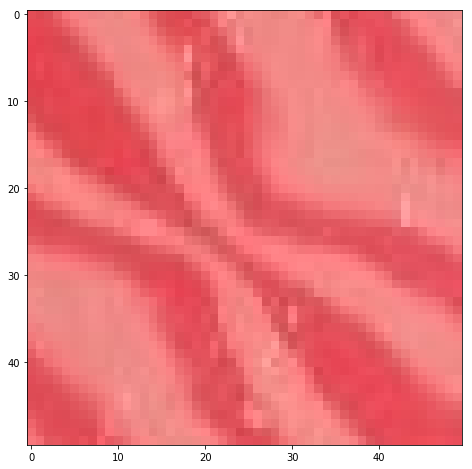

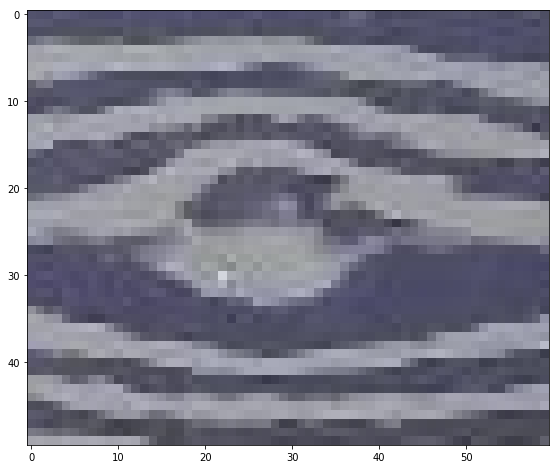

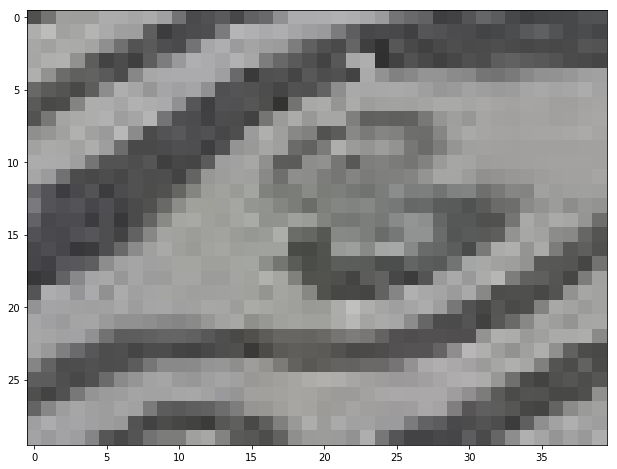

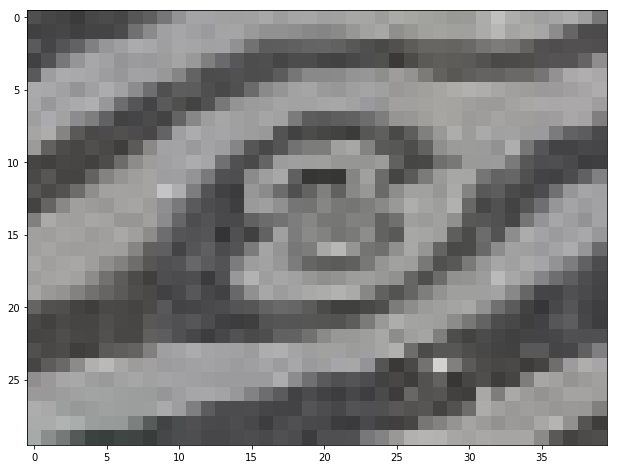

In [604]:
"""
Manually searching for the dent regions 
""" 
plt.imshow(images[0][200:250, 220:270])
plt.figure()
plt.imshow(images[1][160:210, 160:220])
plt.figure()
plt.imshow(images[2][100:130, 200:240])
plt.figure()
plt.imshow(images[2][120:150, 190:230])

In [773]:
# Adding bounding boxes to array
boxes_img0 = ([dlib.rectangle(left=220, top=200, right=270, bottom=250),])
boxes_img1 = ([dlib.rectangle(left=160, top=170, right=210, bottom=210),])
boxes_img2 = ([dlib.rectangle(left=200, top=100, right=240, bottom=130),
               dlib.rectangle(left=190, top=120, right=230, bottom=150),])
boxes = [boxes_img0, boxes_img1, boxes_img2]

### Training a Hog + SVM detector

In [606]:
# Adding some training options with little augmentations
options = dlib.simple_object_detector_training_options()
options.add_left_right_image_flips = True
options.C = 1
options.num_threads = 1
options.be_verbose = True

In [622]:
# Train
detector = dlib.train_simple_object_detector(images, boxes, options)

In [623]:
# Looking on mask
win_det = dlib.image_window()
win_det.set_image(detector)
dlib.hit_enter_to_continue()

In [624]:
# Testing on our images
print("Showing detections on the images in the `dent` folder...")


path = Path("./data/dent/")
for f in sorted(path.rglob('*.png'), key = lambda x: int(x.name[5:-4])):
    print("Processing file: {}".format(f))
    img = dlib.load_rgb_image(str(f.absolute()))
    dets = detector(img)

    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
    print("Number of dents detected: {}".format(len(dets)))
    win = dlib.image_window()
    win.clear_overlay()
    win.set_image(img)
    win.add_overlay(dets)
    win.wait_until_closed()

Showing detections on the images in the `dent` folder...
Processing file: data/dent/dent_1.png
Detection 0: Left: 222 Top: 205 Right: 279 Bottom: 251
Number of dents detected: 1
Processing file: data/dent/dent_2.png
Detection 0: Left: 160 Top: 170 Right: 208 Bottom: 209
Number of dents detected: 1
Processing file: data/dent/dent_3.png
Detection 0: Left: 201 Top: 102 Right: 241 Bottom: 134
Detection 1: Left: 189 Top: 122 Right: 229 Bottom: 154
Number of dents detected: 2


In [625]:
# Saving detector
# detector.save('models/detector_new.weights')

### Results is good but we need more data. 
I don't have ability to find more images, but good and accurae augmentations for that algorithm, will help a lot.
I used ImgAug library to generate more samples for our HOG+SVM classifier
HOG - is oriented gradients. Not all augmentations are good or useful for that type of algorythm. 
So good augmentations for us will be: 
- Blurring
- Affine Transformations
- Elastic Transformations
- Flips and Rotations
- Some noise
- Sharpness
- Contrast
- Little color augmentations (but it's not nenecessary)

#### Test of Augmentations:


In [610]:
import imgaug as ia
from imgaug import augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
rare = lambda aug: iaa.Sometimes(0.1, aug)

In [630]:
# Creating of bounding boxes array to augment them too
bbs1 = ia.BoundingBoxesOnImage([
    ia.BoundingBox(x1=220, y1=200, x2=270, y2=250)
], shape=images[0].shape)

bbs2 = ia.BoundingBoxesOnImage([
    ia.BoundingBox(x1=160, y1=170, x2=210, y2=210)
], shape=images[1].shape)

bbs3 = ia.BoundingBoxesOnImage([
    ia.BoundingBox(x1=200, y1=100, x2=240, y2=130),
    ia.BoundingBox(x1=190, y1=120, x2=230, y2=150)
], shape=images[2].shape)

bbs = [bbs1, bbs2, bbs3]

In [669]:
seq = iaa.Sequential([
#      Flipping and scaling
    iaa.Affine(scale=(0.7, 2.0)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    
    # Adding one of blures sometimes. Little blures is very good for HOG.
    # Motion blure is very important and it should be randomized with some variables too.
    sometimes(iaa.OneOf([
        iaa.GaussianBlur((0, 3.0)),
        iaa.AverageBlur(k=(2, 4)),
        iaa.MedianBlur(k=(3, 5)),
        iaa.MotionBlur((3, 15), (0, 360), (-1, 1), 1),
    ])),
    # Adding some distortion, Perspective Transformation and Elastic transformation     
    sometimes(iaa.OneOf([
        iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=2), # move pixels locally around (with random strengths)
        iaa.PiecewiseAffine(scale=(0.01, 0.02)), # sometimes move parts of the image around
        iaa.PerspectiveTransform(scale=(0.1, 0.3))
    ])),
        
    # Simulate little painting and polishing problems  
    sometimes(iaa.OneOf([
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.1*255), per_channel=0.0),
        iaa.AdditiveLaplaceNoise(loc=0, scale=(0.0, 0.1*255), per_channel=0.0),
        iaa.SaltAndPepper((0.01,0.015)),
    ])),
    
    # Simulate some image compression and other camera parameters
    sometimes(iaa.OneOf([
        iaa.JpegCompression((10,80)),
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 1.5)), # emboss images
    ])),
    # Some colore augmentations. it is not necessary step   
    sometimes(iaa.AddToHueAndSaturation((0, 70), per_channel=1)),
      
])
seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start

In [667]:
# augment keypoints and images
image_aug = seq_det.augment_images(images)
bbs_aug = seq_det.augment_bounding_boxes(bbs)

# image with BBs before/after augmentation (shown below)
image_before = bbs[2].draw_on_image(images[2], thickness=2)
image_after = bbs_aug[2].draw_on_image(image_aug[2], thickness=2, color=[0, 0, 255])

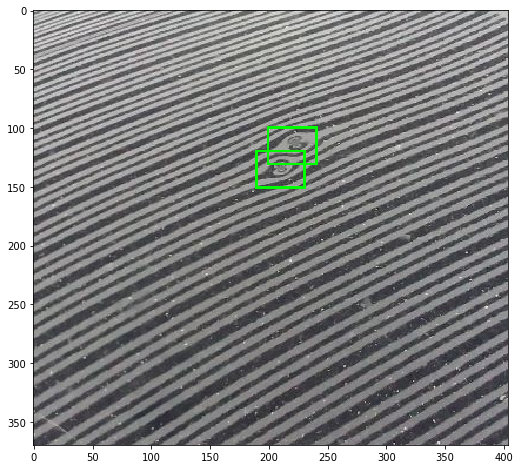

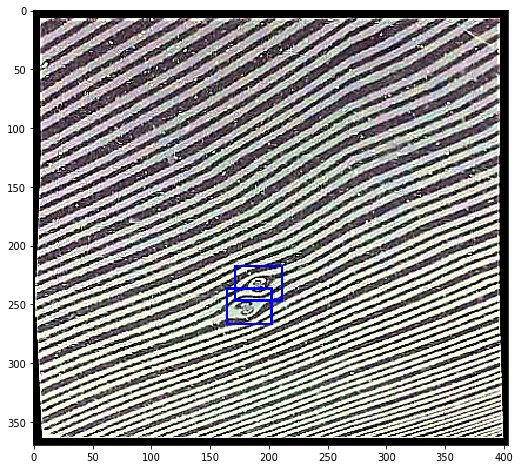

In [668]:
plt.imshow(image_before)
plt.figure()
plt.imshow(image_after)

### Generating extended dataset

In [786]:
images_augmented = []
bounding_boxes_augmented = []

for _ in range(100):
    seq = iaa.Sequential([
    #      Flipping and scaling
        iaa.Affine(scale=(0.7, 2.0)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),

        # Adding one of blures sometimes. Little blures is very good for HOG.
        # Motion blure is very important and it should be randomized with some variables too.
        sometimes(iaa.OneOf([
            iaa.GaussianBlur((0, 3.0)),
            iaa.AverageBlur(k=(2, 4)),
            iaa.MedianBlur(k=(3, 5)),
            iaa.MotionBlur((3, 15), (0, 360), (-1, 1), 1),
        ])),
        # Adding some distortion, Perspective Transformation and Elastic transformation     
        sometimes(iaa.OneOf([
            iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=2), # move pixels locally around (with random strengths)
            iaa.PiecewiseAffine(scale=(0.01, 0.02)), # sometimes move parts of the image around
            iaa.PerspectiveTransform(scale=(0.1, 0.3))
        ])),

        # Simulate little painting and polishing problems  
        sometimes(iaa.OneOf([
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.1*255), per_channel=0.0),
            iaa.AdditiveLaplaceNoise(loc=0, scale=(0.0, 0.1*255), per_channel=0.0),
            iaa.SaltAndPepper((0.01,0.015)),
        ])),

        # Simulate some image compression and other camera parameters
        sometimes(iaa.OneOf([
            iaa.JpegCompression((10,80)),
            iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
            iaa.Emboss(alpha=(0, 1.0), strength=(0, 1.5)), # emboss images
        ])),
        # Some colore augmentations. it is not necessary step   
        sometimes(iaa.AddToHueAndSaturation((0, 70), per_channel=1)),

    ])
    seq_det = seq.to_deterministic()
    
    images_aug = seq_det.augment_images(images)
    bbs_aug = seq_det.augment_bounding_boxes(bbs)
    
    for img_aug, bb_aug in zip(images_aug, bbs_aug):
        images_augmented.append(img_aug)
        bboxes = []
        for bb in bb_aug.bounding_boxes:
            bboxes.append(dlib.rectangle(
                left=int(bb.x1), 
                top=int(bb.y1), 
                right=int(bb.x2), 
                bottom=int(bb.y2)))
        bounding_boxes_augmented.append(bboxes)

[rectangle(127,152,204,213)]


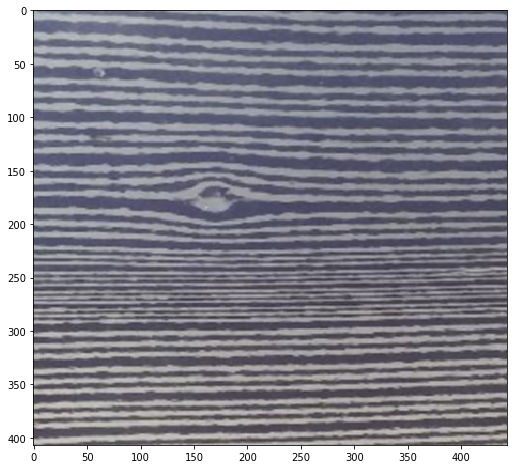

In [787]:
plt.imshow(images_augmented[16])
print(bounding_boxes_augmented[16])

In [799]:
# TODO: distribution and z-value ranges need to be counted
for i, bb_aug in enumerate(bounding_boxes_augmented):
    for bb in bb_aug:
        width = bb.right() - bb.left()
        height = bb.bottom() - bb.top()
        
        if width < 10 or height < 10:
            print('Image was deleted: %s' % i)
            del bounding_boxes_augmented[i]
            del images_augmented[i]
            continue
        
        area = int(height) * int(width)
        ratio = width / height
        
        if ratio < 0.9 or ratio>1.35 or area < 500:
            print('Image was deleted: %s' % i)
            del bounding_boxes_augmented[i]
            del images_augmented[i]
            continue
        print('a: %s r: %s' % (area, ratio))

a: 3717 r: 1.0677966101694916
a: 1692 r: 1.3055555555555556
a: 2376 r: 1.2272727272727273
a: 2279 r: 1.2325581395348837
a: 4480 r: 0.9142857142857143
a: 5780 r: 1.25
a: 5776 r: 1.0
a: 7900 r: 1.2658227848101267
Image was deleted: 7
a: 4088 r: 1.3035714285714286
a: 2655 r: 1.3111111111111111
a: 2596 r: 1.3409090909090908
a: 1936 r: 1.0
a: 1702 r: 1.2432432432432432
Image was deleted: 11
Image was deleted: 11
a: 2914 r: 1.3191489361702127
a: 2961 r: 1.3404255319148937
a: 3660 r: 1.0166666666666666
a: 7900 r: 1.2658227848101267
a: 972 r: 1.3333333333333333
a: 1008 r: 1.2857142857142858
a: 2970 r: 0.9818181818181818
a: 8080 r: 1.2625
a: 1728 r: 1.3333333333333333
Image was deleted: 18
a: 6975 r: 1.24
a: 2520 r: 1.2444444444444445
a: 2475 r: 1.2222222222222223
a: 3080 r: 1.018181818181818
a: 3200 r: 1.28
a: 1376 r: 1.34375
a: 1376 r: 1.34375
a: 6241 r: 1.0
a: 2773 r: 1.2553191489361701
a: 3200 r: 1.28
a: 3136 r: 1.3061224489795917
a: 2401 r: 1.0
a: 5934 r: 1.2463768115942029
a: 7008 r: 1.31

In [801]:
print(len(images_augmented), len(bounding_boxes_augmented))

229 229


In [802]:
# Adding some training options with little augmentations
options = dlib.simple_object_detector_training_options()
options.add_left_right_image_flips = True
options.C = 100
options.num_threads = 1
options.be_verbose = True

# Train
detector = dlib.train_simple_object_detector(images+images_augmented, boxes+bounding_boxes_augmented, options)

In [803]:
# Testing on our images
print("Showing detections on the images in the `dent` folder...")


path = Path("./data/dent/")
for f in sorted(path.rglob('*.png'), key = lambda x: int(x.name[5:-4])):
    print("Processing file: {}".format(f))
    img = dlib.load_rgb_image(str(f.absolute()))
    dets = detector(img)

    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
    print("Number of dents detected: {}".format(len(dets)))
    win = dlib.image_window()
    win.clear_overlay()
    win.set_image(img)
    win.add_overlay(dets)
    win.wait_until_closed()

Showing detections on the images in the `dent` folder...
Processing file: data/dent/dent_1.png
Detection 0: Left: 216 Top: 205 Right: 273 Bottom: 251
Number of dents detected: 1
Processing file: data/dent/dent_2.png
Detection 0: Left: 160 Top: 170 Right: 208 Bottom: 209
Number of dents detected: 1
Processing file: data/dent/dent_3.png
Detection 0: Left: 201 Top: 98 Right: 241 Bottom: 130
Detection 1: Left: 189 Top: 118 Right: 229 Bottom: 150
Number of dents detected: 2


In [805]:
# Looking on mask
win_det = dlib.image_window()
win_det.set_image(detector)
dlib.hit_enter_to_continue()

In [804]:
# detector.save('models/detector_augmented_new.weights')